In [ ]:
import matplotlib.pyplot as plt
import os
import subprocess
import glob

In [3]:

def batch_register_32ch_deltaB0(root_folder, reference_file):
    """
    Uses magnitude images from subfolder 'negative_nii' for registration,
    then applies transform to deltaFieldmap images.

    Parameters:
        root_folder (str): Path to '32ch_coil_profile_nii' folder.
        reference_file (str): Path to reference NIfTI file (e.g., B0_target.nii.gz).

    Returns:
        list: Paths to all successfully registered deltaFieldmap files.
    """
    if not os.path.exists(reference_file):
        raise FileNotFoundError("❌ Reference file not found.")

    registered_paths = []

    for ch in range(1, 33):
        ch_folder = os.path.join(root_folder, f"ch{ch}_nii")
        if not os.path.isdir(ch_folder):
            print(f"⚠️ Skipping {ch_folder} (not a directory)")
            continue

        negative_folder = os.path.join(ch_folder, "negative_nii")
        if not os.path.isdir(negative_folder):
            print(f"❌ negative_nii folder missing in {ch_folder}")
            continue

        # 找到negative_nii里含有e2的magnitude图
        magnitude_files = glob.glob(os.path.join(negative_folder, "*e2*.nii*"))
        if not magnitude_files:
            print(f"❌ Magnitude image not found in {negative_folder}")
            continue
        magnitude_path = magnitude_files[0]

        # 找到 deltaFieldmap 文件，假设在chx_nii目录下，格式 chx_nii_deltaFieldmap.nii.gz
        delta_files = glob.glob(os.path.join(ch_folder, f"ch{ch}_nii_deltaFieldmap.nii*"))
        if not delta_files:
            print(f"❌ deltaFieldmap not found in {ch_folder}")
            continue
        delta_path = delta_files[0]

        reg_mat = os.path.join(ch_folder, f"ch{ch}_reg.mat")
        reg_out = os.path.join(ch_folder, f"ch{ch}_nii_Regis_deltB0.nii.gz")

        try:
            # 用magnitude图配准
            subprocess.run([
                "flirt",
                "-in", magnitude_path,
                "-ref", reference_file,
                "-omat", reg_mat,
                "-dof", "6"
            ], check=True)

            # 应用刚体变换到deltaFieldmap
            subprocess.run([
                "flirt",
                "-in", delta_path,
                "-ref", reference_file,
                "-applyxfm",
                "-init", reg_mat,
                "-out", reg_out
            ], check=True)

            registered_paths.append(reg_out)
            print(f"✅ ch{ch} registered successfully.")

        except subprocess.CalledProcessError:
            print(f"❌ Registration failed for ch{ch}")

    return registered_paths


In [4]:
registered_files = batch_register_32ch_deltaB0(
    root_folder="32ch_coil_profile_nii",
    reference_file="Nifti/infant_group_nii/N173_nii/N173_deltaB0_hertz.nii.gz"
)

print("\n✅ All registered files:")
for path in registered_files:
    print(path)


✅ ch1 registered successfully.
✅ ch2 registered successfully.
✅ ch3 registered successfully.
✅ ch4 registered successfully.
✅ ch5 registered successfully.
✅ ch6 registered successfully.
✅ ch7 registered successfully.
✅ ch8 registered successfully.
✅ ch9 registered successfully.
✅ ch10 registered successfully.
✅ ch11 registered successfully.
✅ ch12 registered successfully.
✅ ch13 registered successfully.
✅ ch14 registered successfully.
✅ ch15 registered successfully.
✅ ch16 registered successfully.
✅ ch17 registered successfully.
✅ ch18 registered successfully.
✅ ch19 registered successfully.
✅ ch20 registered successfully.
✅ ch21 registered successfully.
✅ ch22 registered successfully.
✅ ch23 registered successfully.
✅ ch24 registered successfully.
✅ ch25 registered successfully.
✅ ch26 registered successfully.
✅ ch27 registered successfully.
✅ ch28 registered successfully.
✅ ch29 registered successfully.
✅ ch30 registered successfully.
✅ ch31 registered successfully.
✅ ch32 registered

In [2]:
import os, re
import numpy as np
import nibabel as nib
from scipy.optimize import minimize

target_nii = nib.load(r"Nifti/infant_group_nii/N173_nii/N173_deltaB0_hertz.nii.gz")
B0_target = target_nii.get_fdata() * 1e6
b = B0_target.flatten()
target_shape = B0_target.shape

nifti_folder = r'./32ch_coil_profile_nii'
def natural_key(s):
    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', s)]
sorted_channels = sorted(os.listdir(nifti_folder), key=natural_key)

B0_list = []
for ch_name in sorted_channels:
    delta_path = os.path.join(nifti_folder, ch_name, f"{ch_name}_Regis_deltB0.nii.gz")
    if os.path.exists(delta_path):
        img = nib.load(delta_path)
        B0_ch = img.get_fdata()
        B0_list.append(B0_ch)

B0_array = np.stack(B0_list, axis=-1)
A = B0_array.reshape(-1, B0_array.shape[-1])

n_channels = A.shape[1]
initial_weights = np.ones(n_channels) / n_channels
bounds = [(-4.0, 4.0)] * n_channels  

def loss_mse(w):  # L2 范数
    return np.mean((A @ w + b) ** 2)

def loss_l1(w):  # L1 范数
    return np.mean(np.abs(A @ w + b))

def loss_max(w):  # 最大绝对残差
    return np.max(np.abs(A @ w + b))

def loss_ptp(w):  # peak to peak
    r = A @ w + b
    return r.max() - r.min()

loss_dict = {
    "MSE (L2)": loss_mse,
    "L1": loss_l1,
    "Max Error": loss_max,
    "Peak-to-Peak": loss_ptp,
}

results = {}

for name, loss_func in loss_dict.items():
    print(f"\n>>> 正在拟合目标函数: {name}")
    res = minimize(loss_func, initial_weights, bounds=bounds, method='L-BFGS-B')
    shim_currents = res.x
    residual = A @ shim_currents + b

    results[name] = {
        'currents': shim_currents,
        'residual': residual,
        'loss': loss_func(shim_currents)
    }

for name, data in results.items():
    print(f"\n====== {name} ======")
    print(f"Loss: {data['loss']:.3f}")
    for idx, val in enumerate(data['currents']):
        print(f"ch{idx+1:02d}: {val:.3f} A")

with open("shim_currents_multiobj.txt", "w") as f:
    for name, data in results.items():
        f.write(f"### {name} ###\n")
        for idx, val in enumerate(data['currents']):
            f.write(f"ch{idx+1:02d}: {val:.3f} A\n")
        f.write("\n")



>>> 正在拟合目标函数: MSE (L2)

>>> 正在拟合目标函数: L1

>>> 正在拟合目标函数: Max Error

>>> 正在拟合目标函数: Peak-to-Peak

====== MSE (L2) ======
Loss: 318.598
ch01: 0.142 A
ch02: -0.009 A
ch03: -0.026 A
ch04: 0.085 A
ch05: 0.128 A
ch06: 0.070 A
ch07: -0.224 A
ch08: 0.030 A
ch09: -0.011 A
ch10: 0.052 A
ch11: 0.021 A
ch12: 0.068 A
ch13: 0.120 A
ch14: 0.077 A
ch15: 0.115 A
ch16: 0.421 A
ch17: -0.325 A
ch18: 0.342 A
ch19: 0.078 A
ch20: 0.234 A
ch21: 0.087 A
ch22: -0.023 A
ch23: -0.004 A
ch24: -0.021 A
ch25: 0.015 A
ch26: -0.041 A
ch27: 0.038 A
ch28: 0.060 A
ch29: 0.021 A
ch30: -0.138 A
ch31: -0.088 A
ch32: 0.262 A

====== L1 ======
Loss: 4.730
ch01: 0.056 A
ch02: 0.007 A
ch03: -0.024 A
ch04: 0.044 A
ch05: 0.015 A
ch06: 0.062 A
ch07: -0.184 A
ch08: 0.002 A
ch09: -0.015 A
ch10: 0.001 A
ch11: 0.003 A
ch12: 0.012 A
ch13: 0.019 A
ch14: 0.026 A
ch15: -0.046 A
ch16: 0.301 A
ch17: -0.222 A
ch18: 0.238 A
ch19: 0.110 A
ch20: 0.049 A
ch21: -0.002 A
ch22: -0.000 A
ch23: -0.001 A
ch24: -0.000 A
ch25: 0.003 A
ch26: -0.002 A
ch27

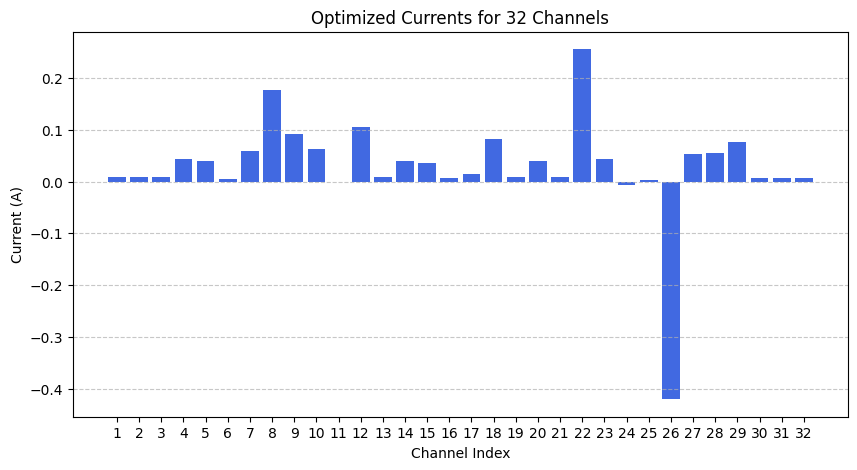

In [3]:
plt.figure(figsize=(10, 5))
plt.bar(range(1, len(shim_currents) + 1), shim_currents, color='royalblue')

plt.xlabel("Channel Index")
plt.ylabel("Current (A)")
plt.title("Optimized Currents for 32 Channels")
plt.xticks(range(1, len(shim_currents) + 1)) 

plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from IPython.display import display


views = {
    'Axial (Z)': lambda vol, idx: vol[:, :, idx],
    'Coronal (Y)': lambda vol, idx: vol[:, idx, :],
    'Sagittal (X)': lambda vol, idx: vol[idx, :, :]
}

max_indices = {
    'Axial (Z)': target_shape[2] - 1,
    'Coronal (Y)': target_shape[1] - 1,
    'Sagittal (X)': target_shape[0] - 1
}

sliders = {
    direction: widgets.IntSlider(value=dim // 2, min=0, max=dim, description=direction.split()[0], continuous_update=False)
    for direction, dim in max_indices.items()
}

def plot_interactive(axial_idx, coronal_idx, sagittal_idx):
    slice_indices = {
        'Axial (Z)': axial_idx,
        'Coronal (Y)': coronal_idx,
        'Sagittal (X)': sagittal_idx
    }

    n_views = len(views)
    n_rows = len(results) + 1
    plt.figure(figsize=(4 * n_views, 3 * n_rows))

    for j, (view_name, slicer) in enumerate(views.items()):
        idx = slice_indices[view_name]
        plt.subplot(n_rows, n_views, j + 1)
        plt.imshow(slicer(B0_target, idx).T, cmap='jet', vmin=-100, vmax=100, origin='lower')
        plt.title(f"Ref - {view_name}")
        plt.colorbar()

    for i, (name, data) in enumerate(results.items()):
        res_3d = data['residual'].reshape(target_shape)
        for j, (view_name, slicer) in enumerate(views.items()):
            idx = slice_indices[view_name]
            plt.subplot(n_rows, n_views, (i + 1) * n_views + j + 1)
            plt.imshow(slicer(res_3d, idx).T, cmap='jet', vmin=-100, vmax=100, origin='lower')
            plt.title(f"{name} - {view_name}")
            plt.colorbar()

    plt.tight_layout()
    plt.show()

# 绑定滑块和绘图函数
ui = widgets.VBox([widgets.HBox(list(sliders.values()))])
out = widgets.interactive_output(plot_interactive, {
    'axial_idx': sliders['Axial (Z)'],
    'coronal_idx': sliders['Coronal (Y)'],
    'sagittal_idx': sliders['Sagittal (X)']
})

display(ui, out)


Output()

In [8]:
def summarize_residual_metrics(results, target_shape, B0_target):
    print("📊 Residual Summary (Hz):")
    print(f"{'Method':<20} {'STD':>10} {'RMSE':>10} {'MIN':>10} {'MAX':>10}")
    print("-" * 60)

    # 添加 B0_target 的统计信息
    target_flat = B0_target.flatten()
    std = np.std(target_flat)
    rmse = np.sqrt(np.mean(target_flat**2))
    rmin = np.min(target_flat)
    rmax = np.max(target_flat)

    print(f"{'B0_target (ref)':<20} {std:10.2f} {rmse:10.2f} {rmin:10.2f} {rmax:10.2f}")

    # 各方法残差的统计信息
    for name, data in results.items():
        residual = data['residual'].reshape(target_shape)
        residual_flat = residual.flatten()

        std = np.std(residual_flat)
        rmse = np.sqrt(np.mean(residual_flat**2))
        rmin = np.min(residual_flat)
        rmax = np.max(residual_flat)

        print(f"{name:<20} {std:10.2f} {rmse:10.2f} {rmin:10.2f} {rmax:10.2f}")
summarize_residual_metrics(results, target_shape, B0_target)


📊 Residual Summary (Hz):
Method                      STD       RMSE        MIN        MAX
------------------------------------------------------------
B0_target (ref)           20.16      20.19    -580.93     552.44
MSE (L2)                  17.84      17.85    -544.89     552.44
L1                        18.56      18.58    -576.51     552.44
Max Error                 27.43      28.01    -506.47     552.44
Peak-to-Peak              24.93      25.71    -482.80     552.44


In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_all_views_with_reference(B0_target, results, target_shape, slice_ids=(28, 64, 28), save_path=None, dpi=300):
# """
# 绘制参考场图与各方法残差的三个方向切片图，并可保存高分辨率图像。

# Parameters:
# B0_target (ndarray): 3D 目标场图。
# results (dict): 每种方法的 {'residual': ndarray}。
# target_shape (tuple): 目标场形状。
# slice_ids (tuple): (sagittal, coronal, axial) 切片索引。
# save_path (str): 若提供路径，将保存为图片。
# dpi (int): 保存图片时的分辨率。
# """
    view_names = ["Sagittal", "Coronal", "Axial"]
    slice_axes = [0, 1, 2]
    num_methods = len(results)
    methods = list(results.keys())

    fig, axes = plt.subplots(
    nrows=num_methods + 1,
    ncols=3,
    figsize=(12, 3 * (num_methods + 1)),
    squeeze=False
    )

# 显示 B0_target
    for j, axis in enumerate(slice_axes):
        idx = slice_ids[j]
        if axis == 0:
            img = B0_target[idx, :, :]
        elif axis == 1:
            img = B0_target[:, idx, :]
        else:
            img = B0_target[:, :, idx]
        ax = axes[0, j]
        im = ax.imshow(img.T, cmap='jet', origin='lower', vmin=-75, vmax=75)
        ax.set_title(f"Ref - {view_names[j]}")
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.01)

# 显示每个方法的 residual
    for i, method in enumerate(methods):
        residual_3d = results[method]['residual'].reshape(target_shape)
        for j, axis in enumerate(slice_axes):
            idx = slice_ids[j]
            if axis == 0:
                img = residual_3d[idx, :, :]
            elif axis == 1:
                img = residual_3d[:, idx, :]
            else:
                img = residual_3d[:, :, idx]
            ax = axes[i + 1, j]
            im = ax.imshow(img.T, cmap='jet', origin='lower', vmin=-75, vmax=75)
            ax.set_title(f"{method} Residual - {view_names[j]}")
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.01)

    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=dpi)
        print(f"✅ 图像已保存到：{save_path}")
    else:
        plt.show()

✅ 图像已保存到：residual_views_comparison_N173.png


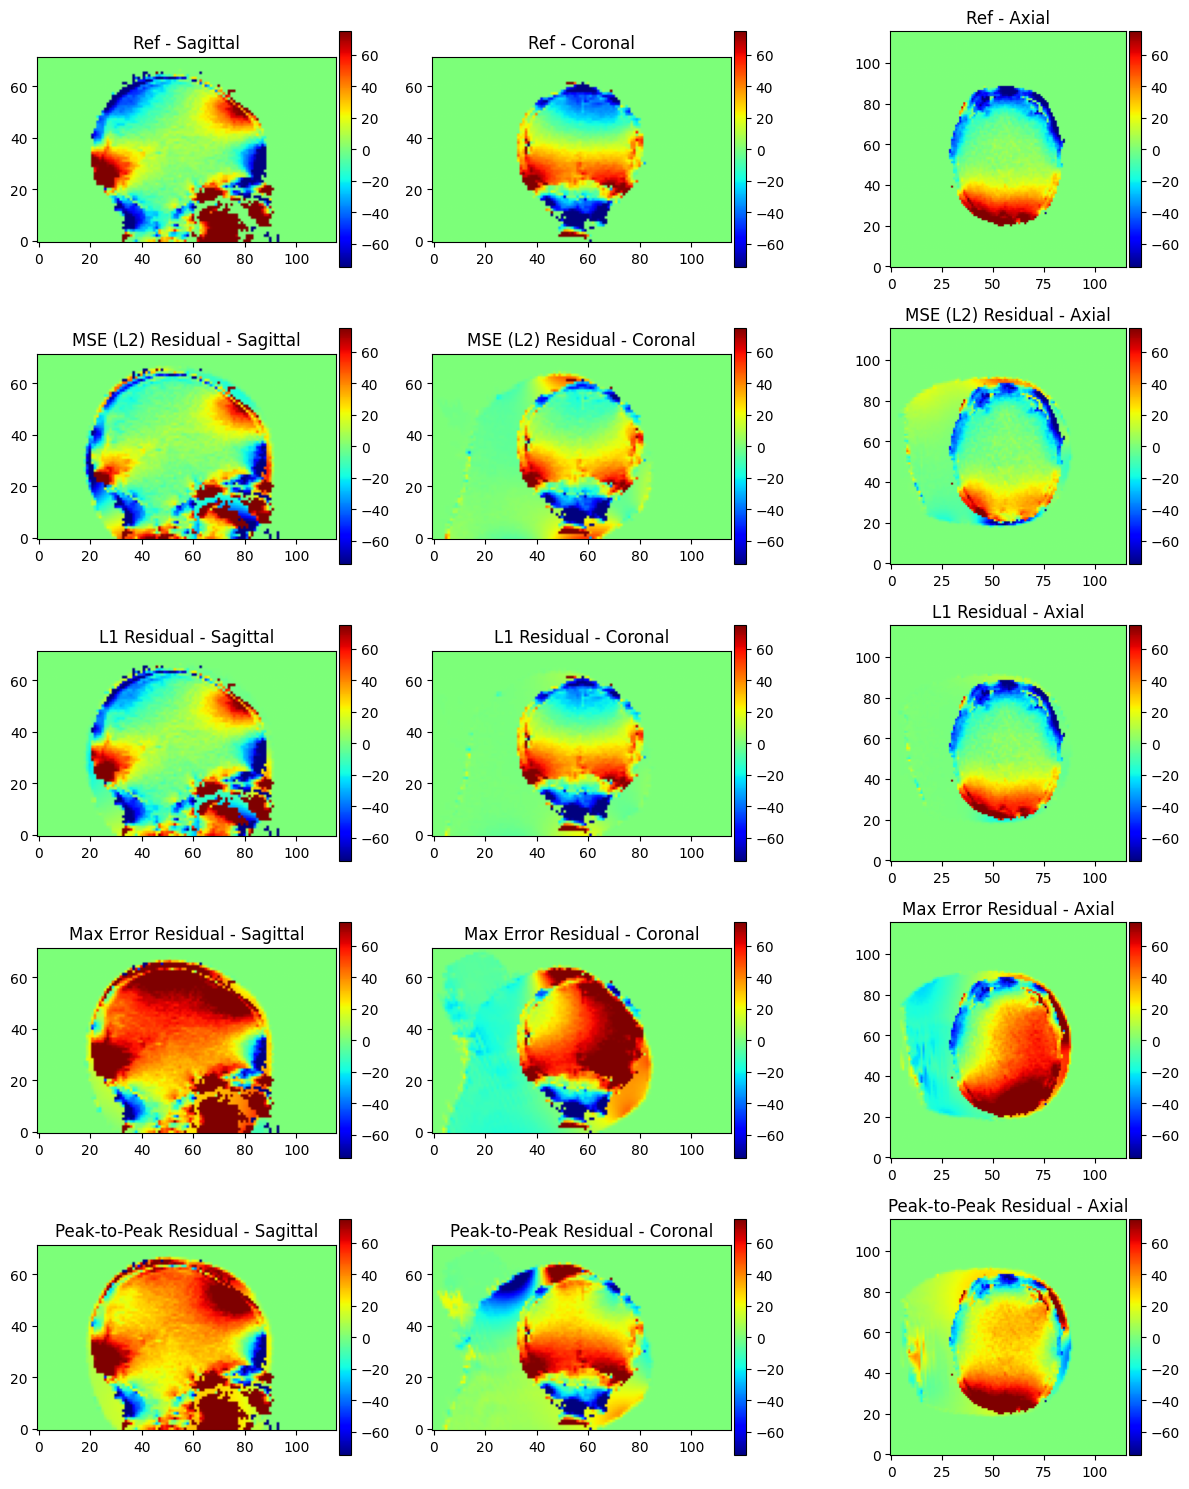

In [10]:
plot_all_views_with_reference(
B0_target,
results,
target_shape,
slice_ids=(57, 35, 31),
save_path="residual_views_comparison_N173.png", # 或 None 来只显示
dpi=300
)

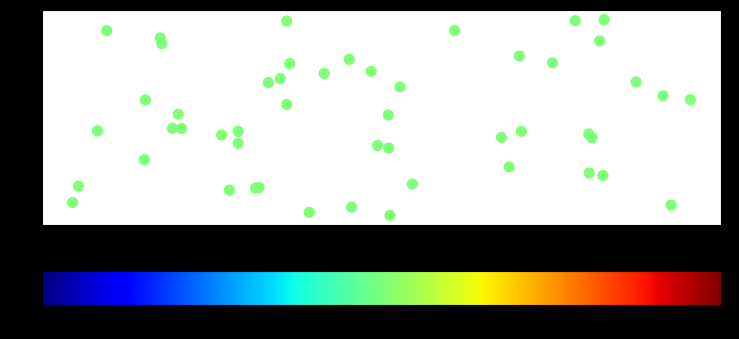

In [ ]:
import os
import re
import numpy as np
import nibabel as nib
from scipy.optimize import minimize

# ========= 路径配置 =========
target_path = r"Nifti/infant_group_nii/N173_nii/N173_deltaB0_hertz.nii.gz"
mask_path = r"B0map_cal/pfc_mask/pfc_mask_qmj.nii.gz"
channel_folder = r"./32ch_coil_profile_nii"

# ========= 工具函数 =========
def natural_key(s):
    return [int(text) if text.isdigit() else text for text in re.split(r'(\d+)', s)]

# ========= 加载目标场 =========
B0_target = nib.load(target_path).get_fdata() * 1e6  # Hz to ppm
mask = nib.load(mask_path).get_fdata()
mask = (mask > 0.5).astype(np.float32)
B0_target[mask < 0.5] = np.nan
b_flat = B0_target.flatten()
valid_idx = ~np.isnan(b_flat)
b = b_flat[valid_idx]

# ========= 加载所有通道响应并应用 mask =========
sorted_channels = sorted(os.listdir(channel_folder), key=natural_key)
B0_list = []
for ch_name in sorted_channels:
    ch_path = os.path.join(channel_folder, ch_name, f"{ch_name}_Regis_deltB0.nii.gz")
    if os.path.exists(ch_path):
        B0_ch = nib.load(ch_path).get_fdata()
        B0_ch[mask < 0.5] = np.nan
        B0_list.append(B0_ch)
    else:
        print(f"[警告] 通道 {ch_name} 缺失文件：{ch_path}")

# ========= 构造 A 矩阵 =========
B0_array = np.stack(B0_list, axis=-1)                     # shape: (X, Y, Z, n_channels)
A = B0_array.reshape(-1, B0_array.shape[-1])              # shape: (N_vox, n_channels)
A = A[valid_idx]                                          # 仅保留有效区域
n_channels = A.shape[1]

# ========= 优化配置 =========
initial_weights = np.ones(n_channels) / n_channels
bounds = [(-4.0, 4.0)] * n_channels  # 每通道电流范围 ±4A

# ========= 损失函数定义 =========
def loss_mse(w): return np.mean((A @ w + b) ** 2)
def loss_l1(w): return np.mean(np.abs(A @ w + b))
def loss_max(w): return np.max(np.abs(A @ w + b))
def loss_ptp(w): r = A @ w + b; return r.max() - r.min()

loss_dict = {
    "MSE (L2)": loss_mse,
    "L1": loss_l1,
    "Max Error": loss_max,
    "Peak-to-Peak": loss_ptp,
}

# ========= 多目标优化求解 =========
results = {}
for name, loss_func in loss_dict.items(): 
    print(f"\n>>> 正在拟合目标函数: {name}")
    res = minimize(loss_func, initial_weights, bounds=bounds, method='L-BFGS-B')
    shim_currents = res.x
    residual = A @ shim_currents + b

    results[name] = {
        'currents': shim_currents,
        'residual': residual,
        'loss': loss_func(shim_currents)
    }

# ========= 打印 & 保存结果 =========
with open("shim_currents_pfc.txt", "w") as f:
    for name, data in results.items():
        print(f"\n====== {name} ======")
        print(f"Loss: {data['loss']:.3f}")
        f.write(f"### {name} ###\n")
        f.write(f"Loss: {data['loss']:.3f}\n")
        for idx, val in enumerate(data['currents']):
            line = f"ch{idx+1:02d}: {val:.3f} A"
            print(line)
            f.write(line + "\n")
        f.write("\n")

print("\n✅ 前额叶ROI匀场优化完成，结果已保存至 shim_currents_pfc.txt")
